# Selection on Observables

## Purpose

The purpose of this notebook is to illustrate an example of the workflow outlined in [Brathwaite and Walker (2017)](https://arxiv.org/abs/1706.07502). This simple application aims at highlighting the importance of causal structure in estimating causal effects of interest reflecting changes resulting from policy proposals. The basic idea is to show that when we control for intermediate variables of some variable of interest in a causal graph, we never recover the true causal parameter on the variable of interest.

This notebook uses the dataset and the MNL utility specification from [Brathwaite and Walker (2016)](https://arxiv.org/abs/1606.05900) for demonstration.
The rest of the notebook is organized as follows:
 - Defining different causal graphs representing different views for how individuals make mode choices. These causal graphs are based on the MNL utility functions from [Brathwaite and Walker (2016)](https://arxiv.org/abs/1606.05900)
 - Simulating data based on the different beliefs about the data generating process illustrated by both causal graphs.
 - Perturbing one of the variables (e.g.: Travel Distance) to simulate a policy intervention.
 - Calculating and plotting the distributions of treatment effects according to different causal graphs.

# Import Needed Libraries

In [1]:
# Built-in libraries
import sys

# Third party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
import seaborn as sns
import copy
from causalgraphicalmodels import CausalGraphicalModel
from collections import defaultdict, OrderedDict
import pylogit as pl

# Local libraries
import causal2020.observables.distfit as distfit
import causal2020.observables.simulation as sim
import causal2020.observables.regression as reg
import causal2020.observables.availability as av
from checkrs.utils import simulate_choice_vector
from causal2020.observables.graphs import (
    IND_UTILITY,
    DA_UTILITY,
    SHARED_2_UTILITY,
    SHARED_3P_UTILITY,
    WTW_UTILITY,
    DTW_UTILITY,
    WTD_UTILITY,
    WALK_UTILITY,
    BIKE_UTILITY,
)

# Set Notebook Parameters

In [2]:
# Path to Data
DATA_PATH = "../../data/raw/spring_2016_all_bay_area_long_format_plus_cross_bay_col.csv"

# Path to computational code used
# in simulation loop
SIMULATE_NODES_WIDE = open("../../src/observables/simworkflow.py").read()
SIMULATE_PERTURB = open("../../src/observables/simperturb.py").read()

In [3]:
# Alternative id column from long format data
ALT_ID_COL = "mode_id"

# Individual specific variables list
IND_SPEC_VARS = [
    "household_size",
    "num_kids",
    "num_cars",
    "num_licensed_drivers",
]

# Alternative specific variables dictionary
# Key is alternative number, value is a list
# of alternative specific nodes without parents
ALT_SPEC_DICT = {
    1: ["total_travel_distance"],
    2: ["total_travel_distance"],
    3: ["total_travel_distance"],
    4: ["total_travel_time"],
    5: ["total_travel_time"],
    6: ["total_travel_time"],
    7: ["total_travel_distance"],
    8: ["total_travel_distance"],
}

# Trip specific variables list
TRIP_SPEC_VARS = ["cross_bay"]

# Alternative name dictionary
# Key is alternative number
# value is alternative number snake cased
ALT_NAME_DICT = {
    1: "drive_alone",
    2: "shared_2",
    3: "shared_3p",
    4: "wtw",
    5: "dtw",
    6: "wtd",
    7: "walk",
    8: "bike",
}

ALT_ID_TO_MODE_NAME = {
    1: "Drive Alone",
    2: "Shared Ride 2",
    3: "Shared Ride 3+",
    4: "Walk-Transit-Walk",
    5: "Drive-Transit-Walk",
    6: "Walk-Transit-Drive",
    7: "Walk",
    8: "Bike",
}

# Variable type Dictionary
# Key is string with variable name from previous
# dictionaries and lists, value is a string
# with type of the variable
VARS_TYPE = {
    "num_kids": "categorical",
    "household_size": "categorical",
    "num_cars": "categorical",
    "num_licensed_drivers": "categorical",
    "cross_bay": "categorical",
    "total_travel_time": "continuous",
    "total_travel_distance": "continuous",
    "total_travel_cost": "continuous",
}

# Distribution to be explored for continuous variables
CONT_DISTS = ["norm", "alpha", "beta", "gamma", "expon", "gumbel"]

In [4]:
# Declare regression parameters

REGS_DA = {
    1: ("total_travel_distance", "total_travel_cost"),
    2: ("total_travel_distance", "total_travel_time"),
}

REGS_TYPE_DA = {1: "linear", 2: "linear"}


REGS_SHARED_2 = {
    1: ("total_travel_distance", "total_travel_cost"),
    2: ("total_travel_distance", "total_travel_time"),
}

REGS_TYPE_SHARED_2 = {1: "linear", 2: "linear"}


REGS_SHARED_3P = {
    1: ("total_travel_distance", "total_travel_cost"),
    2: ("total_travel_distance", "total_travel_time"),
}

REGS_TYPE_SHARED_3P = {1: "linear", 2: "linear"}


REGS_WTW = {1: ("total_travel_time", "total_travel_cost")}

REGS_TYPE_WTW = {1: "linear"}


REGS_DTW = {1: ("total_travel_time", "total_travel_cost")}

REGS_TYPE_DTW = {1: "linear"}


REGS_WTD = {1: ("total_travel_time", "total_travel_cost")}

REGS_TYPE_WTD = {1: "linear"}

In [5]:
# Parameters for conversion from Wide to Long

IND_VARIABLES = [
    "num_kids",
    "household_size",
    "num_cars",
    "num_licensed_drivers",
    "cross_bay",
]


# Dictionary of Alternative Specific Variables
# TODO: verify whether all variables are needed
# for each alternative
ALT_VARYING_VARIABLES = {
    u"total_travel_time": dict(
        [
            (1, "total_travel_time_drive_alone"),
            (2, "total_travel_time_shared_2"),
            (3, "total_travel_time_shared_3p"),
            (4, "total_travel_time_wtw"),
            (5, "total_travel_time_dtw"),
            (6, "total_travel_time_wtd"),
        ]
    ),
    u"total_travel_cost": dict(
        [
            (1, "total_travel_cost_drive_alone"),
            (2, "total_travel_cost_shared_2"),
            (3, "total_travel_cost_shared_3p"),
            (4, "total_travel_cost_wtw"),
            (5, "total_travel_cost_dtw"),
            (6, "total_travel_cost_wtd"),
        ]
    ),
    u"total_travel_distance": dict(
        [
            (1, "total_travel_distance_drive_alone"),
            (2, "total_travel_distance_shared_2"),
            (3, "total_travel_distance_shared_3p"),
            (7, "total_travel_distance_walk"),
            (8, "total_travel_distance_bike"),
        ]
    ),
}


# Dictionary of alternative availability variables
AVAILABILITY_VARIABLES = {
    1: "drive_alone_AV",
    2: "shared_2_AV",
    3: "shared_3p_AV",
    4: "wtw_AV",
    5: "dtw_AV",
    6: "wtd_AV",
    7: "walk_AV",
    8: "bike_AV",
}

##########
# Determine the columns for: alternative ids, the observation ids and the choice
##########
# The 'custom_alt_id' is the name of a column to be created in the long-format data
# It will identify the alternative associated with each row.
CUSTOM_ALT_ID = "mode_id"

OBS_ID_COL = "observation_id"

# Declare choice column
CHOICE_COL = "sim_choice"

In [6]:
# Create my specification and variable names for the basic MNL model
# NOTE: - Keys should be variables within the long format dataframe.
#         The sole exception to this is the "intercept" key.
#       - For the specification dictionary, the values should be lists
#         or lists of lists. Within a list, or within the inner-most
#         list should be the alternative ID's of the alternative whose
#         utility specification the explanatory variable is entering.

MNL_SPECIFICATION = OrderedDict()
MNL_NAMES = OrderedDict()

MNL_SPECIFICATION["intercept"] = [2, 3, 4, 5, 6, 7, 8]
MNL_NAMES["intercept"] = [
    "ASC Shared Ride: 2",
    "ASC Shared Ride: 3+",
    "ASC Walk-Transit-Walk",
    "ASC Drive-Transit-Walk",
    "ASC Walk-Transit-Drive",
    "ASC Walk",
    "ASC Bike",
]

MNL_SPECIFICATION["total_travel_time"] = [[1, 2, 3], [4, 5, 6]]
MNL_NAMES["total_travel_time"] = [
    "Travel Time, units:min (All Auto Modes)",
    "Travel Time, units:min (All Transit Modes)",
]

MNL_SPECIFICATION["total_travel_cost"] = [[4, 5, 6]]
MNL_NAMES["total_travel_cost"] = ["Travel Cost, units:$ (All Transit Modes)"]

MNL_SPECIFICATION["cost_per_distance"] = [1, 2, 3]
MNL_NAMES["cost_per_distance"] = [
    "Travel Cost per Distance, units:$/mi (Drive Alone)",
    "Travel Cost per Distance, units:$/mi (SharedRide-2)",
    "Travel Cost per Distance, units:$/mi (SharedRide-3+)",
]

MNL_SPECIFICATION["cars_per_licensed_drivers"] = [[1, 2, 3]]
MNL_NAMES["cars_per_licensed_drivers"] = [
    "Autos per licensed drivers (All Auto Modes)"
]

MNL_SPECIFICATION["total_travel_distance"] = [7, 8]
MNL_NAMES["total_travel_distance"] = [
    "Travel Distance, units:mi (Walk)",
    "Travel Distance, units:mi (Bike)",
]

MNL_SPECIFICATION["cross_bay"] = [[2, 3]]
MNL_NAMES["cross_bay"] = ["Cross-Bay Tour (Shared Ride 2 & 3+)"]

MNL_SPECIFICATION["household_size"] = [[2, 3]]
MNL_NAMES["household_size"] = ["Household Size (Shared Ride 2 & 3+)"]

MNL_SPECIFICATION["num_kids"] = [[2, 3]]
MNL_NAMES["num_kids"] = ["Number of Kids in Household (Shared Ride 2 & 3+)"]

# Load and Describe Data

In [7]:
# Reading data from the specified PATH
bike_data_long = pd.read_csv(DATA_PATH)

# Look at the mode shares in the data set

mode_counts = (
    bike_data_long.loc[bike_data_long.choice == 1, "mode_id"]
    .value_counts()
    .loc[range(1, 9)]
)

mode_shares = mode_counts / bike_data_long.observation_id.max()
mode_shares.index = [ALT_ID_TO_MODE_NAME[x] for x in mode_shares.index.values]
mode_shares.name = "Mode Shares"
mode_shares

Drive Alone           0.428322
Shared Ride 2         0.158841
Shared Ride 3+        0.139860
Walk-Transit-Walk     0.103397
Drive-Transit-Walk    0.015485
Walk-Transit-Drive    0.013237
Walk                  0.094406
Bike                  0.046454
Name: Mode Shares, dtype: float64

# Choice Model Estimation

For purposes of this task, we use the MNL specification from Brathwaite and Walker (2016) and estimate the model resulting from such a specification. We assume that the estimated model parameters represent the "true" model parameters.

In [8]:
# Estimate the basic MNL model, using the hessian and newton-conjugate gradient
mnl_model = pl.create_choice_model(
    data=bike_data_long,
    alt_id_col=ALT_ID_COL,
    obs_id_col=OBS_ID_COL,
    choice_col="choice",
    specification=MNL_SPECIFICATION,
    model_type="MNL",
    names=MNL_NAMES,
)

num_vars = len(reduce(lambda x, y: x + y, MNL_NAMES.values()))

# Note newton-cg used to ensure convergence to a point where gradient
# is essentially zero for all dimensions.
mnl_model.fit_mle(np.zeros(num_vars), method="BFGS")

# Look at the estimation results
mnl_model.get_statsmodels_summary()

Log-likelihood at zero: -7,599.7019
Initial Log-likelihood: -7,599.7019


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimation Time for Point Estimation: 0.34 seconds.
Final log-likelihood: -5,073.4276


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                      choice   No. Observations:                4,004
Model:             Multinomial Logit Model   Df Residuals:                    3,985
Method:                                MLE   Df Model:                           19
Date:                     Mon, 30 Nov 2020   Pseudo R-squ.:                   0.332
Time:                             23:07:55   Pseudo R-bar-squ.:               0.330
AIC:                            10,184.855   Log-Likelihood:             -5,073.428
BIC:                            10,304.461   LL-Null:                    -7,599.702
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
ASC Shared Ride: 2                                      -1.0097      0.486     -2.079      0.038      -1.962      -0.058
ASC Shared Ride: 3+                                      3.4619      1.064      3.254      0.001       1.377       5.547
ASC Walk-Transit-Walk                                   -0.3921      0.288     -1.360      0.174      -0.957       0.173
ASC Drive-Transit-Walk                                  -2.6220      0.303     -8.660      0.000      -3.215      -2.029
ASC Walk-Transit-Drive                                  -2.9773      0.306     -9.725      0.000      -3.577      -2.377
ASC Walk                                                 1.5541      0.305      5.101      0.000       0.957       2.151
ASC Bike                                                -1.1059      0.305     -3.628      0.000      -1.703      -0.508
Travel Time, units:min (All Auto Modes)                 -0.0760      0.006    -13.728      0.000      -0.087      -0.065
Travel Time, units:min (All Transit Modes)              -0.0274      0.002    -12.768      0.000      -0.032      -0.023
Travel Cost, units:$ (All Transit Modes)                -0.1273      0.037     -3.472      0.001      -0.199      -0.055
Travel Cost per Distance, units:$/mi (Drive Alone)      -5.0613      1.377     -3.675      0.000      -7.760      -2.362
Travel Cost per Distance, units:$/mi (SharedRide-2)    -20.3194      4.548     -4.467      0.000     -29.234     -11.405
Travel Cost per Distance, units:$/mi (SharedRide-3+)   -90.9224     14.748     -6.165      0.000    -119.829     -62.016
Autos per licensed drivers (All Auto Modes)              1.2134      0.129      9.408      0.000       0.961       1.466
Travel Distance, units:mi (Walk)                        -1.0272      0.050    -20.437      0.000      -1.126      -0.929
Travel Distance, units:mi (Bike)                        -0.2873      0.024    -11.896      0.000      -0.335      -0.240
Cross-Bay Tour (Shared Ride 2 & 3+)                      0.9280      0.327      2.839      0.005       0.287       1.569
Household Size (Shared Ride 2 & 3+)                      0.1136      0.045      2.523      0.012       0.025       0.202
Number of Kids in Household (Shared Ride 2 & 3+)         0.6868      0.054     12.820      0.000       0.582       0.792
========================================================================================================================
"""

# Show Causal Graphs

We generate two causal graphs based on the data at hand and the specified utility functions from above:

 * An "independent" causal graph: All nodes are independent and do not affect each other. Any change in any variable in the graph would not result in changes in other variables and would only affect the value of the utility function.
 * A "realistic" causal graph: The structure of this causal graph shows that some variables affect others. In this example, a change in travel distance affects travel time, travel cosst, and directly affects the utility function.

The outcome of each of the causal graphs is the utility of each variable. As such, we generate causal graphs based on the utility specification for each alternative.

## Independent Causal Graph

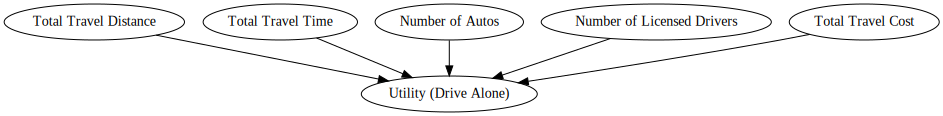

In [9]:
IND_UTILITY.draw()

## Realistic Causal Graphs

## Drive Alone

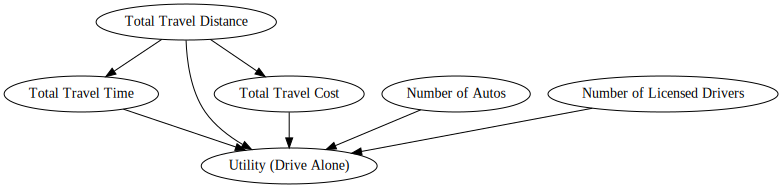

In [10]:
DA_UTILITY.draw()

## Shared-2

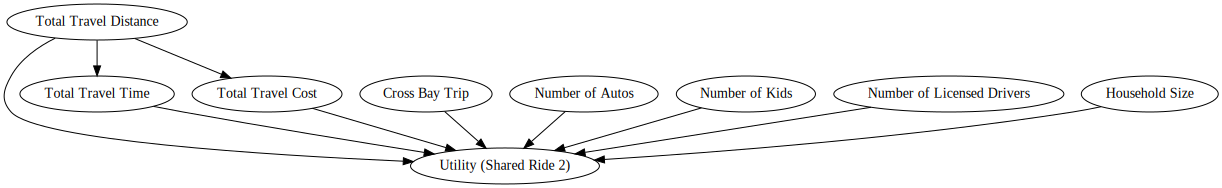

In [11]:
SHARED_2_UTILITY.draw()

## Shared-3+

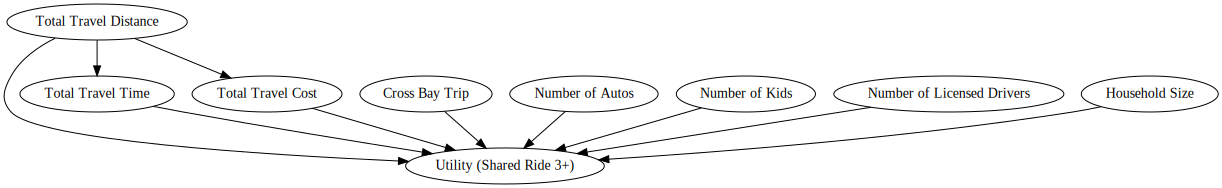

In [12]:
SHARED_3P_UTILITY.draw()

## Walk-Transit-Walk

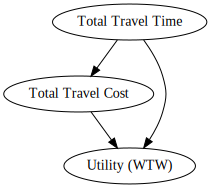

In [13]:
WTW_UTILITY.draw()

## Drive-Transit-Walk

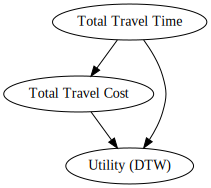

In [14]:
DTW_UTILITY.draw()

##  Walk-Transit-Drive

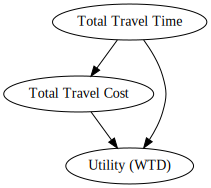

In [15]:
WTD_UTILITY.draw()

## Walk

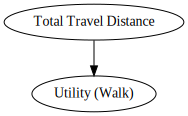

In [16]:
WALK_UTILITY.draw()

## Bike

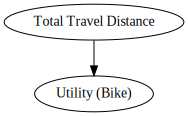

In [17]:
BIKE_UTILITY.draw()

# Selection on Observables Simulation

We simulate data based on the assumed structure of the causal diagrams and the original data from [Brathwaite and Walker (2016)](https://arxiv.org/abs/1606.05900). This process goes as follows:

For the independent causal graph:
 * We fit a probability distribution for all the nodes in the utility function

For the realistic causal graph:
 * We fit a probability distribution for all the nodes without any parents/upstream notes in the causal graphs
 * We fit any regressions between the related explanatory variables

Based on these fitted distributions and regressions, we can then simulate data for the remaining nodes in each of the alternatives in our specified model.

## Distribution Fitting

In [18]:
bike_data_params = distfit.get_dist_node_no_parent(
    bike_data_long,
    ALT_ID_COL,
    OBS_ID_COL,
    ALT_SPEC_DICT,
    ALT_NAME_DICT,
    IND_SPEC_VARS,
    TRIP_SPEC_VARS,
    VARS_TYPE,
    CONT_DISTS,
)

Getting Distributions of Individual Specific Variables...
---------------------------------------------------------
Done...
Getting Distributions of Alternative Specific Variables...
----------------------------------------------------------


Done...
Getting Distributions of Trip Specific Variables...
---------------------------------------------------------
Done...


## Regression Fitting

Based on the structure of the "realistic" causal graphs assumed for each of the alternatives, we fit regressions that will allow us to simulate the remaining nodes in the causal graphs. The utility node will be simulated based on the utility function for each alternative.

## Drive Alone

In [19]:
drive_alone_df = bike_data_long.loc[bike_data_long["mode_id"] == 1]

drive_alone_df.reset_index(drop=True, inplace=True)

fitted_reg_da = reg.fit_alternative_regression(
    regressions=REGS_DA, reg_types=REGS_TYPE_DA, data=drive_alone_df
)

## Shared-2

In [20]:
shared_2_df = bike_data_long.loc[bike_data_long["mode_id"] == 2]

shared_2_df.reset_index(drop=True, inplace=True)

fitted_reg_shared_2 = reg.fit_alternative_regression(
    regressions=REGS_SHARED_2, reg_types=REGS_TYPE_SHARED_2, data=shared_2_df
)

## Shared-3+

In [21]:
shared_3p_df = bike_data_long.loc[bike_data_long["mode_id"] == 3]

shared_3p_df.reset_index(drop=True, inplace=True)

fitted_reg_shared_3p = reg.fit_alternative_regression(
    regressions=REGS_SHARED_3P,
    reg_types=REGS_TYPE_SHARED_3P,
    data=shared_3p_df,
)

## Walk-Transit-Walk

In [22]:
wtw_df = bike_data_long.loc[bike_data_long["mode_id"] == 4]

wtw_df.reset_index(drop=True, inplace=True)

fitted_reg_wtw = reg.fit_alternative_regression(
    regressions=REGS_WTW, reg_types=REGS_TYPE_WTW, data=wtw_df
)

## Drive-Transit-Walk

In [23]:
dtw_df = bike_data_long.loc[bike_data_long["mode_id"] == 5]

dtw_df.reset_index(drop=True, inplace=True)

fitted_reg_dtw = reg.fit_alternative_regression(
    regressions=REGS_DTW, reg_types=REGS_TYPE_DTW, data=dtw_df
)

## Walk-Transit-Drive

In [24]:
wtd_df = bike_data_long.loc[bike_data_long["mode_id"] == 6]

wtd_df.reset_index(drop=True, inplace=True)

fitted_reg_wtd = reg.fit_alternative_regression(
    regressions=REGS_WTD, reg_types=REGS_TYPE_WTD, data=wtd_df
)

## Simulation

Identifying the probability distributions of parent nodes and identifying the relationships between connected nodes allows us to complete the selection-on-observables simulation. The workflow proceeds as follows:
* Simulate two sets of data for the X variables:
  - One where all the Xs are independent (i.e. the only edges in the causal graph are between the X and the outcome variable (which is the value of the utility function)).
  - One based on a realistic causal graph with confounders. The confounder in this simple example is Travel Distance.
* For each of the two causal graphs mentioned in the previous step, simulate choice data based on the outcome model assumed from [Brathwaite and Walker (2016)](https://arxiv.org/abs/1606.05900).
* Estimate the choice model for each of those two datasets using the assumed choice model specification.
* Apply the do-operator (perturbation) to the variable of interest (Travel Distance), and show that the predicted outcome would be accurate only if our causal graph captures the dependency between the explanatory variables.

### Simulation Parameters

In [25]:
simulation_sizes = np.random.randint(low=3000, high=4000, size=30)
sim_number = np.arange(1, 31)
models_dictionary = defaultdict(dict)
causal_effect_dictionary = {}
perturb = 0.8
simulation_data = {}
causal_effects = pd.DataFrame(
    columns=["naive_effect", "true_effect", "estimated_effect"]
)

In [26]:
for sim_size, number in zip(simulation_sizes, sim_number):
    print("Simulation number", number, "is in progress...")
    print("Simulation size is", sim_size)
    print("------------------------------------------")
    print("Simulating data...")
    # Simulate data without parents
    sim_bike_data_no_parent = sim.sim_node_no_parent(
        params_dict=bike_data_params, size=sim_size
    )

    sim_bike_data_wide = copy.deepcopy(sim_bike_data_no_parent)

    # Simulate nodes based on causal graphs
    exec(SIMULATE_NODES_WIDE)

    # Converting Data from Wide to Long
    print("Converting data from wide to long...")
    long_sim_data = pl.convert_wide_to_long(
        wide_data=sim_bike_data_wide,
        ind_vars=IND_VARIABLES,
        alt_specific_vars=ALT_VARYING_VARIABLES,
        availability_vars=AVAILABILITY_VARIABLES,
        obs_id_col=OBS_ID_COL,
        choice_col=CHOICE_COL,
        new_alt_id_name=CUSTOM_ALT_ID,
    )

    # Create a cars per licensed drivers column
    long_sim_data["cars_per_licensed_drivers"] = 0
    long_sim_data.loc[
        long_sim_data.num_licensed_drivers > 0, "cars_per_licensed_drivers"
    ] = long_sim_data.num_cars / long_sim_data.num_licensed_drivers.astype(
        float
    )

    # Add a variable representing cost divided by distance
    long_sim_data["cost_per_distance"] = 0
    long_sim_data.loc[
        long_sim_data.mode_id.isin([1, 2, 3]), "cost_per_distance"
    ] = (
        long_sim_data.loc[
            long_sim_data.mode_id.isin([1, 2, 3]), "total_travel_cost"
        ]
        / long_sim_data.loc[
            long_sim_data.mode_id.isin([1, 2, 3]), "total_travel_distance"
        ]
    )

    # Simulating Choices
    print("Simulating Choices...")
    # Calculate probabilities for each alternative
    # based on the estimated model
    init_mnl_model_probs = mnl_model.predict(long_sim_data)

    # Simulate choice data
    long_sim_data[CHOICE_COL] = simulate_choice_vector(
        predicted_probs=init_mnl_model_probs,
        observation_ids=long_sim_data[OBS_ID_COL].values,
    )

    # Estimating Choice Models
    print("Estimating the choice model...")
    # Estimate the basic MNL model, using the hessian and newton-conjugate gradient
    mnl_model_sim = pl.create_choice_model(
        data=long_sim_data,
        alt_id_col=ALT_ID_COL,
        obs_id_col=OBS_ID_COL,
        choice_col=CHOICE_COL,
        specification=MNL_SPECIFICATION,
        model_type="MNL",
        names=MNL_NAMES,
    )

    num_vars = len(reduce(lambda x, y: x + y, MNL_NAMES.values()))
    # Note newton-cg used to ensure convergence to a point where gradient
    # is essentially zero for all dimensions.
    mnl_model_sim_params = mnl_model_sim.fit_mle(
        np.zeros(num_vars), method="BFGS", just_point=True
    )
    mnl_model_sim_param_list = [mnl_model_sim_params["x"], None, None, None]
    models_dictionary[number] = mnl_model_sim

    print("Estimating Causal Effects...")

    # Estimating Causal Effects
    # Create copies of long format data
    long_sim_data_naive = copy.deepcopy(long_sim_data)
    long_sim_data_causal = copy.deepcopy(long_sim_data)

    # Initial Probabilities
    init_mnl_model_sim_probs = mnl_model_sim.predict(
        long_sim_data, param_list=mnl_model_sim_param_list
    )

    long_sim_data["init_mnl_model_sim_probs"] = init_mnl_model_sim_probs

    # mnl_model_probs = mnl_model.predict(long_sim_data)
    long_sim_data["init_mnl_model_probs"] = init_mnl_model_probs

    long_sim_data_naive["total_travel_distance"] = (
        perturb * long_sim_data_naive["total_travel_distance"]
    )
    long_sim_data_causal["total_travel_distance"] = (
        perturb * long_sim_data["total_travel_distance"]
    )

    # Naive Probabilities
    naive_probabilities = mnl_model_sim.predict(
        long_sim_data_naive, param_list=mnl_model_sim_param_list
    )

    long_sim_data_naive["naive_probabilities"] = naive_probabilities

    # Estimated Probabilities

    exec(SIMULATE_PERTURB)

    # Compute Estimated Probabilities
    estimated_probabilities = mnl_model_sim.predict(
        long_sim_data_causal, param_list=mnl_model_sim_param_list
    )
    long_sim_data_causal["estimated_probabilities"] = estimated_probabilities

    # True Probabilities
    true_probabilities = mnl_model.predict(long_sim_data_causal)
    long_sim_data_causal["true_probabilities"] = true_probabilities

    simulation_data[number] = {}
    simulation_data[number]["long_sim_data"] = long_sim_data
    simulation_data[number]["long_sim_data_causal"] = long_sim_data_causal
    simulation_data[number]["long_sim_data_naive"] = long_sim_data_naive

    print("Simulation number", number, "is complete!")
    print("==========================================")
    print("==========================================")

Simulation number 1 is in progress...
Simulation size is 3317
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

Simulating Choices:   0%|          | 0/3317 [00:00<?, ?it/s]

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3317/3317 [00:00<00:00, 35138.89it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 1 is complete!
Simulation number 2 is in progress...
Simulation size is 3693
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3693/3693 [00:00<00:00, 37415.67it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 2 is complete!
Simulation number 3 is in progress...
Simulation size is 3255
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fae897b95f0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3255/3255 [00:00<00:00, 35337.76it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 3 is complete!
Simulation number 4 is in progress...
Simulation size is 3125
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fae897b95f0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3125/3125 [00:00<00:00, 36968.66it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fae897b95f0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Simulation number 4 is complete!
Simulation number 5 is in progress...
Simulation size is 3712
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

Simulating Choices:   0%|          | 0/3712 [00:00<?, ?it/s]

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3712/3712 [00:00<00:00, 38820.27it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 5 is complete!
Simulation number 6 is in progress...
Simulation size is 3916
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fae897b95f0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3916/3916 [00:00<00:00, 40898.13it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 6 is complete!
Simulation number 7 is in progress...
Simulation size is 3774
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fae897b95f0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3774/3774 [00:00<00:00, 38379.37it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 7 is complete!
Simulation number 8 is in progress...
Simulation size is 3719
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fae897b95f0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3719/3719 [00:00<00:00, 38599.64it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 8 is complete!
Simulation number 9 is in progress...
Simulation size is 3578
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fae897b95f0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3578/3578 [00:00<00:00, 37717.58it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 9 is complete!
Simulation number 10 is in progress...
Simulation size is 3167
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fae897b95f0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3167/3167 [00:00<00:00, 35893.99it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 10 is complete!
Simulation number 11 is in progress...
Simulation size is 3356
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fae897b95f0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3356/3356 [00:00<00:00, 37560.66it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 11 is complete!
Simulation number 12 is in progress...
Simulation size is 3729
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fae897b95f0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3729/3729 [00:00<00:00, 37417.96it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 12 is complete!
Simulation number 13 is in progress...
Simulation size is 3161
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fae897b95f0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3161/3161 [00:00<00:00, 35538.85it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 13 is complete!
Simulation number 14 is in progress...
Simulation size is 3925
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fae897b95f0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3925/3925 [00:00<00:00, 39240.21it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 14 is complete!
Simulation number 15 is in progress...
Simulation size is 3366
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fae897b95f0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3366/3366 [00:00<00:00, 36191.25it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 15 is complete!
Simulation number 16 is in progress...
Simulation size is 3071
------------------------------------------
Simulating data...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fae897b95f0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

Simulating Choices:   0%|          | 0/3071 [00:00<?, ?it/s]

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3071/3071 [00:00<00:00, 35752.13it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 16 is complete!
Simulation number 17 is in progress...
Simulation size is 3423
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fae897b95f0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3423/3423 [00:00<00:00, 37101.24it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 17 is complete!
Simulation number 18 is in progress...
Simulation size is 3132
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fae897b95f0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3132/3132 [00:00<00:00, 35624.47it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 18 is complete!
Simulation number 19 is in progress...
Simulation size is 3546
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fae897b95f0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3546/3546 [00:00<00:00, 39303.93it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 19 is complete!
Simulation number 20 is in progress...
Simulation size is 3728
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fae897b95f0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3728/3728 [00:00<00:00, 39073.04it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 20 is complete!
Simulation number 21 is in progress...
Simulation size is 3514
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fae897b95f0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3514/3514 [00:00<00:00, 37741.53it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 21 is complete!
Simulation number 22 is in progress...
Simulation size is 3004
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fae897b95f0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3004/3004 [00:00<00:00, 35543.24it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fae897b95f0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
AttributeError: 'tqdm_notebook' object has no attribute 'sp'
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated

Simulation number 22 is complete!
Simulation number 23 is in progress...
Simulation size is 3340
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

Simulating Choices:   0%|          | 0/3340 [00:00<?, ?it/s]

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3340/3340 [00:00<00:00, 37343.43it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 23 is complete!
Simulation number 24 is in progress...
Simulation size is 3651
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fae897b95f0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3651/3651 [00:00<00:00, 36686.81it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 24 is complete!
Simulation number 25 is in progress...
Simulation size is 3376
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fae897b95f0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3376/3376 [00:00<00:00, 37805.89it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 25 is complete!
Simulation number 26 is in progress...
Simulation size is 3311
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fae897b95f0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3311/3311 [00:00<00:00, 36060.90it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 26 is complete!
Simulation number 27 is in progress...
Simulation size is 3781
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fae897b95f0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...



Simulating Choices: 100%|██████████| 3781/3781 [00:00<00:00, 35289.63it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 27 is complete!
Simulation number 28 is in progress...
Simulation size is 3359
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fae897b95f0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3359/3359 [00:00<00:00, 37361.25it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 28 is complete!
Simulation number 29 is in progress...
Simulation size is 3344
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fae897b95f0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3344/3344 [00:00<00:00, 37305.51it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 29 is complete!
Simulation number 30 is in progress...
Simulation size is 3857
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fae897b95f0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3857/3857 [00:00<00:00, 39043.57it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 30 is complete!


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fae897b95f0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

### Causal Effect Estimation

We estimate the causal effect related to the perturbation of the Travel Distance variable in each of the causal graphs (independent and realistic) on the probability of choosing Driving based modes (Drive alone, Shared-2, and Shared-3+).

In [27]:
for number in sim_number:

    initial_data = simulation_data[number]["long_sim_data"]
    naive_data = simulation_data[number]["long_sim_data_naive"]
    causal_data = simulation_data[number]["long_sim_data_causal"]

    naive_effect = (
        naive_data.loc[
            naive_data["mode_id"].isin([1, 2, 3]), "naive_probabilities"
        ]
        - initial_data.loc[
            initial_data["mode_id"].isin([1, 2, 3]), "init_mnl_model_sim_probs"
        ]
    )
    estimated_effect = (
        causal_data.loc[
            causal_data["mode_id"].isin([1, 2, 3]), "estimated_probabilities"
        ]
        - initial_data.loc[
            initial_data["mode_id"].isin([1, 2, 3]), "init_mnl_model_sim_probs"
        ]
    )
    true_effect = (
        causal_data.loc[
            causal_data["mode_id"].isin([1, 2, 3]), "true_probabilities"
        ]
        - initial_data.loc[
            initial_data["mode_id"].isin([1, 2, 3]), "init_mnl_model_probs"
        ]
    )

    causal_effects = causal_effects.append(
        {
            "true_effect": true_effect.mean(),
            "estimated_effect": estimated_effect.mean(),
            "naive_effect": naive_effect.mean(),
        },
        ignore_index=True,
    )

### Generating Plots

We plot the distribution of the causal effects to show the bias in predicted outcomes based on the assumed causal graph.

/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


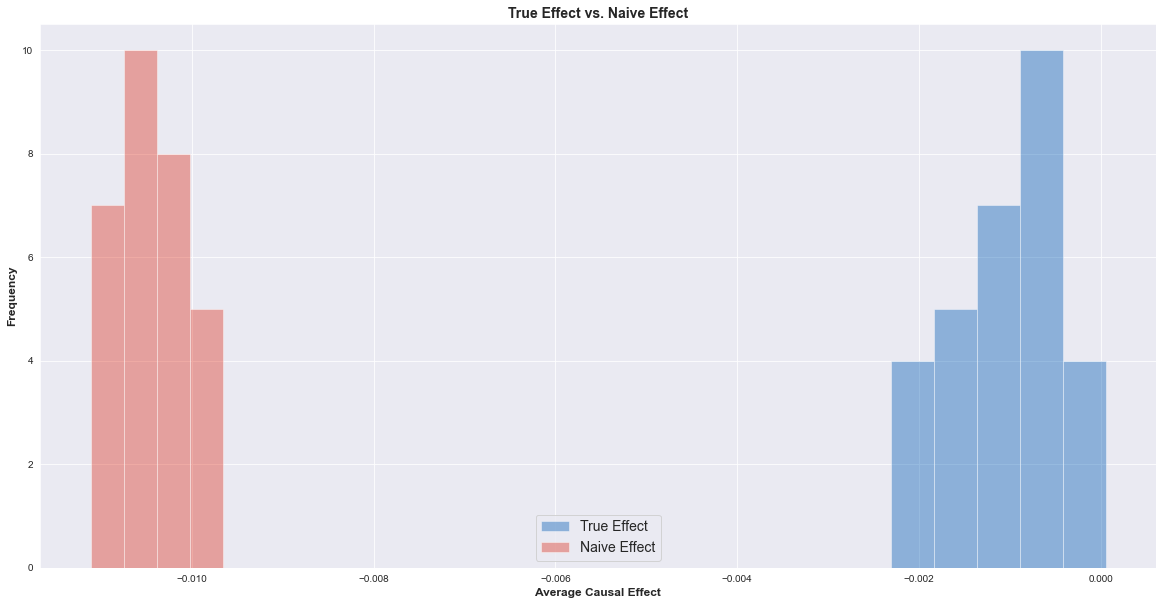

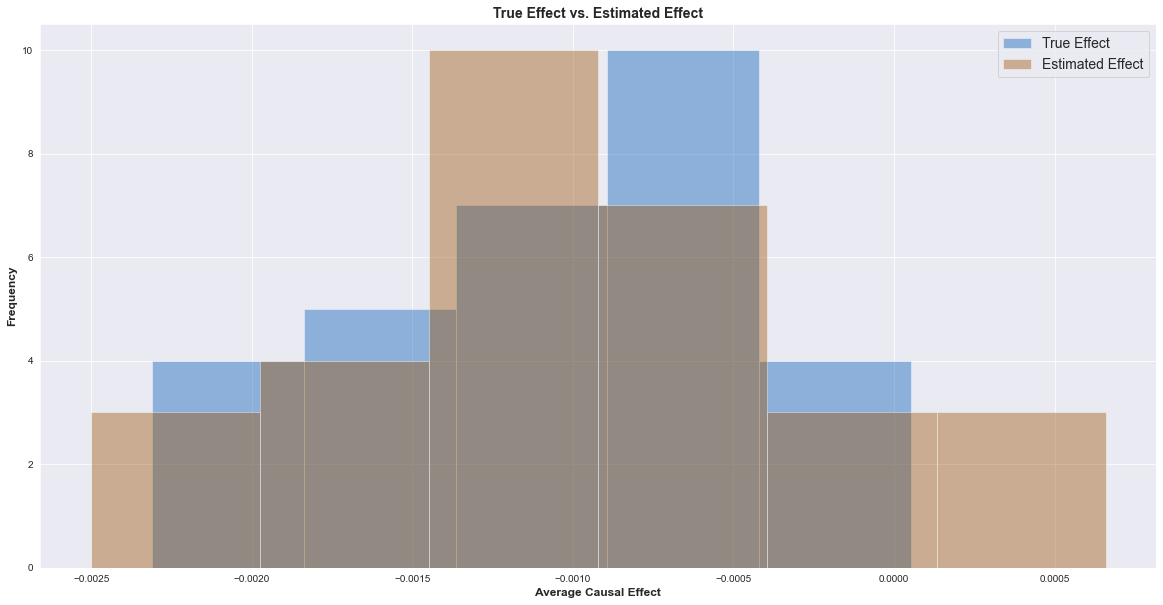

In [28]:
plt.figure(figsize=(20, 10))
sns.distplot(
    causal_effects.true_effect, label="True Effect", kde=False, color="#005AB5"
)
sns.distplot(
    causal_effects.naive_effect,
    label="Naive Effect",
    kde=False,
    color="#DC3220",
)
plt.title(
    "True Effect vs. Naive Effect",
    fontdict={"fontsize": 14, "fontweight": "bold"},
)
plt.ylabel(
    "Frequency",
    rotation=90,
    labelpad=5,
    fontdict={"fontsize": 12, "fontweight": "bold"},
)
plt.xlabel(
    "Average Causal Effect", fontdict={"fontsize": 12, "fontweight": "bold"}
)
plt.legend(prop={"size": 14})

plt.figure(figsize=(20, 10))
sns.distplot(
    causal_effects.true_effect, label="True Effect", kde=False, color="#005AB5"
)
sns.distplot(
    causal_effects.estimated_effect,
    label="Estimated Effect",
    kde=False,
    color="#994F00",
)
plt.title(
    "True Effect vs. Estimated Effect",
    fontdict={"fontsize": 14, "fontweight": "bold"},
)
plt.ylabel(
    "Frequency",
    rotation=90,
    labelpad=5,
    fontdict={"fontsize": 12, "fontweight": "bold"},
)
plt.xlabel(
    "Average Causal Effect", fontdict={"fontsize": 12, "fontweight": "bold"}
)
plt.legend(prop={"size": 14})

# Conclusion

The main conclusion from this notebook is that assigning causal intepretations to model parameters is only valid if we draw clear assumptions about the data generation process about the question at hand. The data generating process was shown to be important even as the outcome model remained unchanged. Drawing a causal graph (and testing its validity with the data at hand) allows one to clearly state their assumptions about the data generating process and to clearly assign causal interpretations to specific model parameters.